In [ ]:
!pip install mplfinance

In [ ]:
!pip install yfinance pandas numpy matplotlib mplfinance ta scikit-learn --upgrade

In [ ]:
!pip install mplfinance ta lightgbm

Iniciando script...
Ticker: ETH-USD, Período: 2020-03-30 a 2025-03-29
Descargando datos para ETH-USD desde 2020-03-30 hasta 2025-03-29...
Advertencia: MultiIndex detectado. Aplanando...
Datos descargados y estandarizados.

--- Métricas Anualizadas ---
Retorno Log Promedio Anual: 0.3672
Volatilidad Anual: 0.6597

Calculando Indicadores Técnicos...
Indicadores Técnicos calculados (incl. OBV, ADX, Lagged Return, EMA_100).

Generando gráficos...


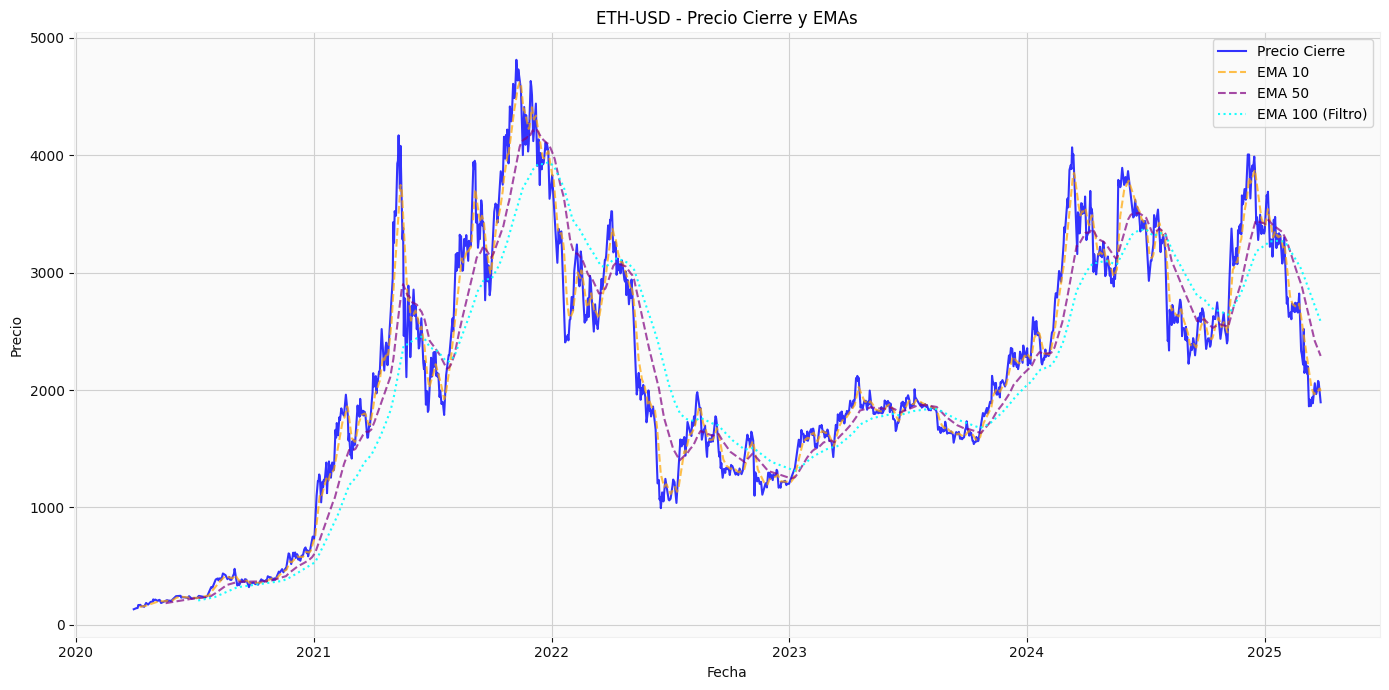

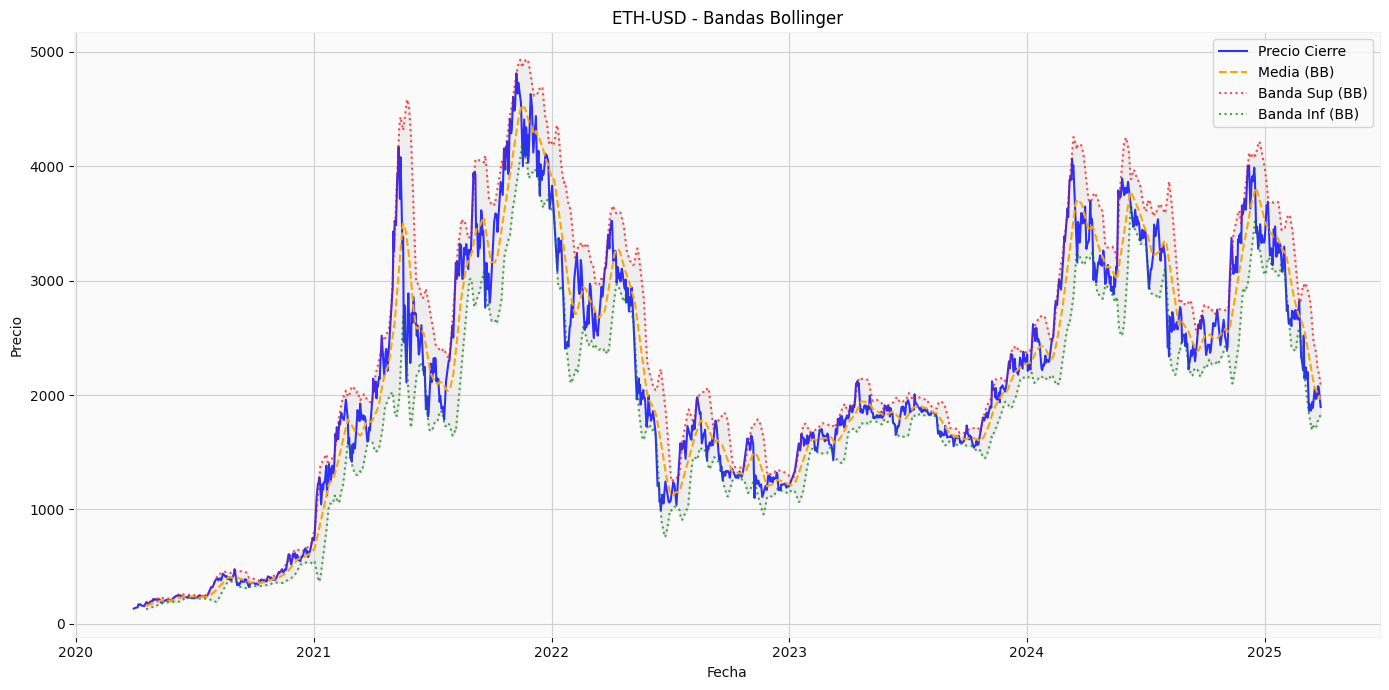

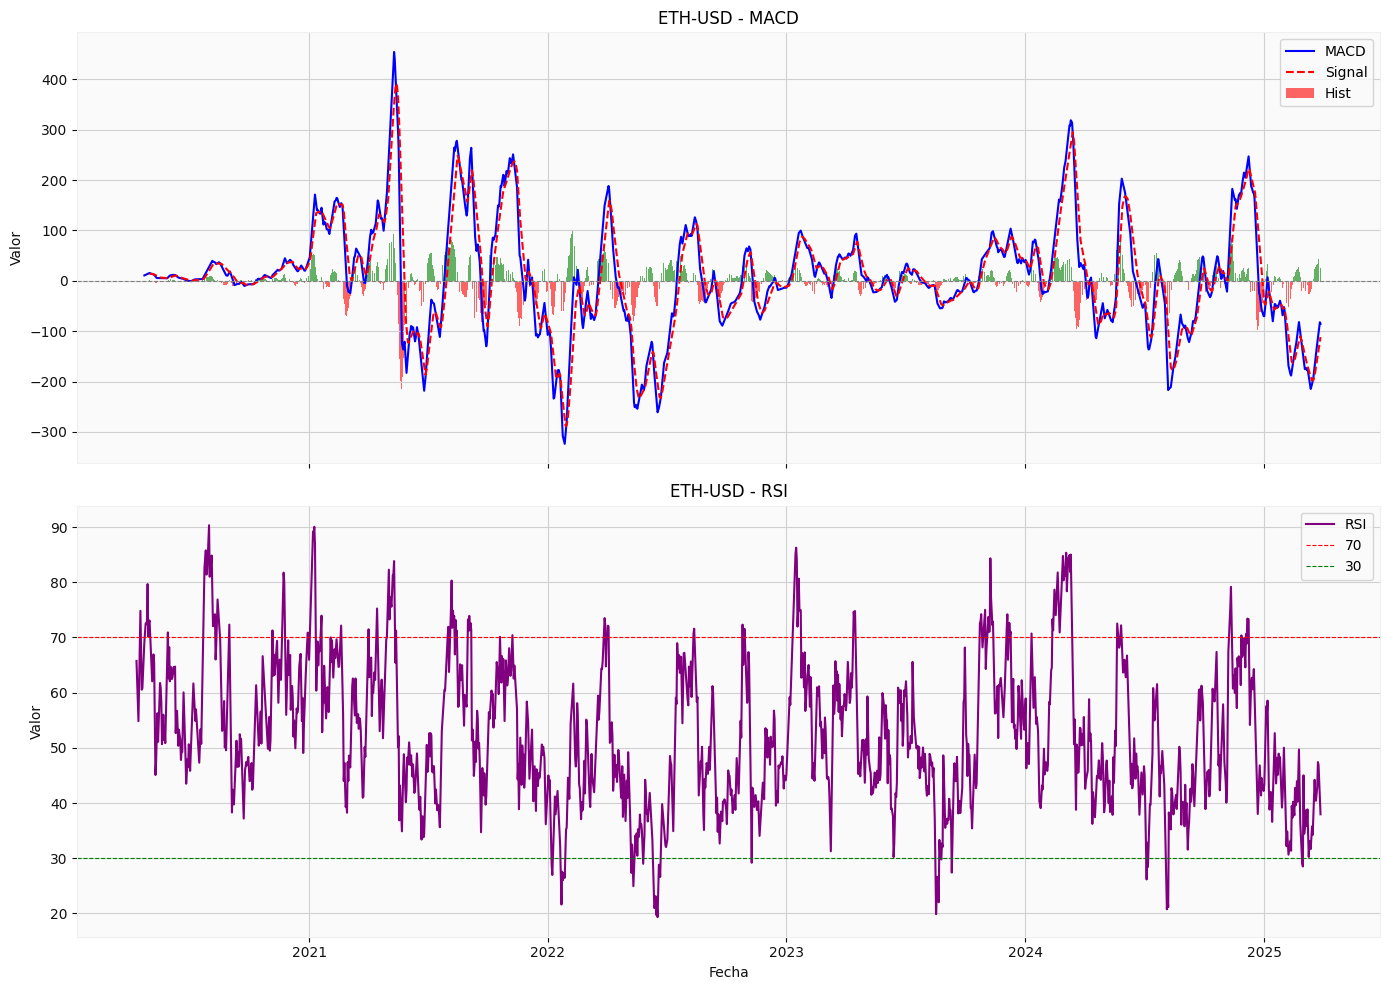


Graficando velas (90 días)...


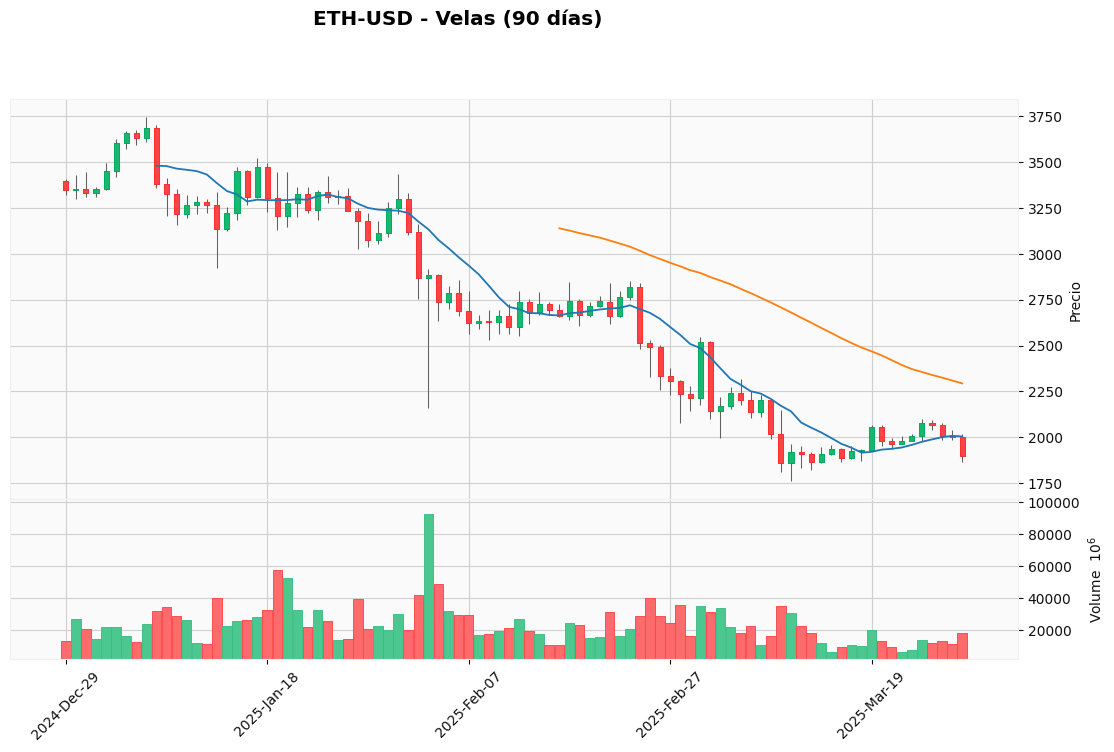


Preparando datos para ML (limpieza, target, retornos futuros)...
Manejo NaNs: Se eliminaron 100 filas.
Datos preparados: 1725 filas listas.

Dividiendo con TimeSeriesSplit (n_splits=5)...
División final: Train 1438 (0-1437), Test 287 (1438-1724)
  Target en Test: [144 143]

Escalando features...
Features escaladas.

--- Optimización de Hiperparámetros: Random Forest ---
Ejecutando RandomizedSearchCV RF (n_iter=30, cv=5)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejor puntuación CV RF (roc_auc): 0.5078
Mejores hiperparámetros RF:
{'class_weight': 'balanced_subsample', 'max_depth': np.int64(21), 'max_features': np.float64(0.8050390834897804), 'min_samples_leaf': 16, 'min_samples_split': 16, 'n_estimators': 264}

--- Entrenando y Evaluando: Random Forest (Optimized) ---
Accuracy: 0.5436
AUC: 0.5536
Confusion Matrix:
[[65 79]
 [52 91]]


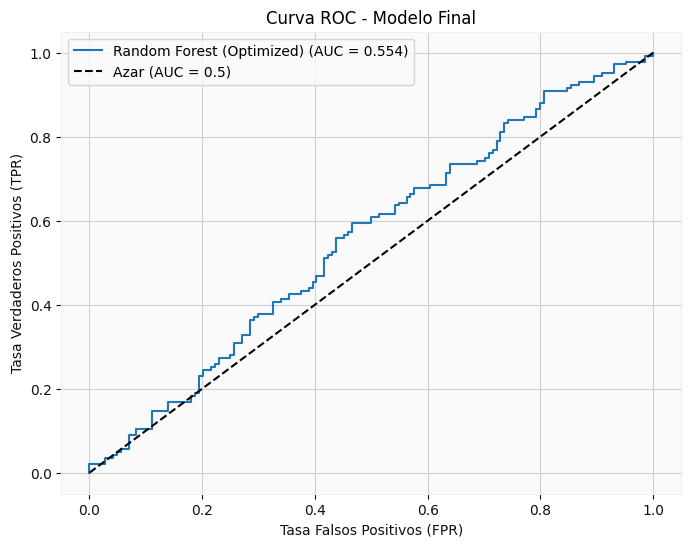


Guardando modelo final en: rf_model_ETH-USD.joblib
Guardando scaler en: scaler_ETH-USD.joblib

--- Backtest Final (Modelo: Random Forest (Optimized)) ---

--- Ejecutando Backtest (Filtro EMA>100, L>0.60, S<0.40, Comm=0.100%, Slip=0.050%) ---
--- Métricas Backtest NET (con Filtro) ---
  Thresholds (L/S): 0.60/0.40
  Total Return NET (%): 17.3158
  Total Return BH (%): -45.5358
  Sharpe Ratio NET (Ann.): 1.1638
  Max Drawdown NET (%): -4.8549
  Num Trades: 17.0000


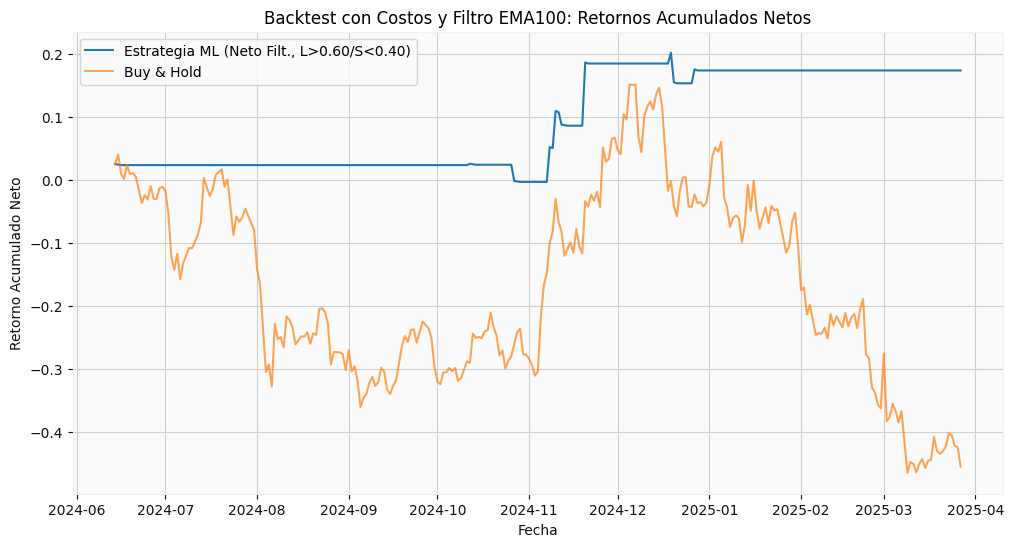


Script finalizado.


'\nConsideraciones sobre Bases de Datos y Protección de Datos:\n\n1.  Almacenamiento de Datos: Persistencia (SQL, Time-Series DB, NoSQL), Actualización incremental.\n2.  Protección de Datos (Si aplica): Datos públicos vs. privados, GDPR/LOPDGDD (Anonimización, Consentimiento, Seguridad, Minimización), Gestión segura de Claves API.\n3.  Mejoras Futuras del Modelo: Más Features, Hyperparameter Tuning (RF hecho, considerar otros), Cross-Validation Temporal (Implementado), Modelos más Avanzados (XGBoost, LSTMs), Backtesting Riguroso (Costos y filtro simple implementados, avanzar a libs), Ensemble Methods, Análisis de Features, Optimización de Umbrales (Análisis de sensibilidad hecho).\n'

In [ ]:
# -*- coding: utf-8 -*-
"""
Algoritmo de negociación basado en Machine Learning

Este script descarga datos financieros, calcula indicadores técnicos,
optimiza y entrena un modelo Random Forest para predecir la dirección
del precio, y evalúa su rendimiento mediante backtesting con costos y filtro.

"""

# --- 1. Importaciones ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import math
from datetime import datetime, timedelta
import warnings
import traceback
from scipy.stats import randint
import joblib # Para guardar/cargar modelos

# Indicadores Técnicos (librería TA)
import ta
from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import MACD, EMAIndicator, SMAIndicator, ADXIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volume import OnBalanceVolumeIndicator

# Machine Learning (Scikit-learn)
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier # Eliminado
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
# import lightgbm as lgb # Eliminado

# Ignorar advertencias comunes
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in log")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# --- 2. Constantes y Configuración ---
TRADING_DAYS_PER_YEAR = 252
DEFAULT_TICKER = 'ETH-USD'
YEARS_OF_DATA = 5
END_DATE = datetime.today() - timedelta(days=1)
START_DATE = END_DATE - timedelta(days=YEARS_OF_DATA * 365)
END_DATE_STR = END_DATE.strftime('%Y-%m-%d')
START_DATE_STR = START_DATE.strftime('%Y-%m-%d')

# Parámetros Indicadores
SHORT_WINDOW=10; MEDIUM_WINDOW=20; LONG_WINDOW=50; RSI_WINDOW=14; MACD_FAST=12;
MACD_SLOW=26; MACD_SIGN=9; BB_WINDOW=MEDIUM_WINDOW; BB_STD_DEV=2; ATR_WINDOW=14;
STOCH_WINDOW=14; STOCH_SMOOTH=3; ADX_WINDOW=14
TREND_FILTER_WINDOW = 100

# Parámetros ML y Backtest
N_SPLITS_TSCV = 5
N_ITER_SEARCH_RF = 30
CV_SCORING = 'roc_auc'
COMMISSION_PER_TRADE = 0.001
SLIPPAGE_PER_TRADE = 0.0005
BACKTEST_THRESHOLD_LONG = 0.60 # Umbrales óptimos encontrados
BACKTEST_THRESHOLD_SHORT = 0.40

MODEL_FILENAME = f'rf_model_{DEFAULT_TICKER}.joblib'
SCALER_FILENAME = f'scaler_{DEFAULT_TICKER}.joblib'

# Features y Target
FEATURE_LIST = [
    f'EMA_{SHORT_WINDOW}', f'EMA_{MEDIUM_WINDOW}', f'EMA_{LONG_WINDOW}', 'RSI', 'ATR',
    'MACD_diff', 'BB_width', 'Stoch_Signal', 'OBV', 'ADX', 'return_log_1d'
]
TARGET_VAR = 'Target'


# --- 3. Funciones Auxiliares ---

def fetch_data(ticker, start, end):
    """Descarga datos históricos, maneja errores y estandariza columnas."""
    print(f"Descargando datos para {ticker} desde {start} hasta {end}...")
    try:
        data = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=False, actions=False)
        if data is None or not isinstance(data, pd.DataFrame) or data.empty: print(f"Error: Problema con datos de yf.download."); return None
        if isinstance(data.columns, pd.MultiIndex):
            print("Advertencia: MultiIndex detectado. Aplanando..."); data.columns = data.columns.get_level_values(0)
            if data.columns.duplicated().any(): data = data.loc[:, ~data.columns.duplicated(keep='first')]
        original_cols_lower = {col: str(col).lower().replace(' ', '_') for col in data.columns}; data.rename(columns=original_cols_lower, inplace=True)
        close_col_source = 'adj_close' if 'adj_close' in data.columns else 'close' if 'close' in data.columns else None
        if not close_col_source: print("Error: No se encontró 'adj_close' ni 'close'."); return None
        data['close'] = data[close_col_source]
        if close_col_source == 'adj_close' and 'adj_close' in data.columns: data.drop('adj_close', axis=1, inplace=True, errors='ignore')
        required = ['open', 'high', 'low', 'close', 'volume']; missing = [c for c in required if c not in data.columns]
        if missing: print(f"Error: Faltan OHLCV: {missing}."); return None
        print("Datos descargados y estandarizados.")
        return data
    except Exception as e: print(f"Error en fetch_data: {e}"); traceback.print_exc(); return None

def calculate_returns_volatility(df):
    """Calcula retornos y volatilidad."""
    if 'close' not in df.columns: print("Error: Falta 'close' para retornos."); return df, None, None
    if not isinstance(df['close'], pd.Series): print(f"Error: 'close' no es Serie."); return df, None, None
    df['return_daily'] = df['close'].pct_change(); df['return_log'] = np.log(df['close'] / df['close'].shift(1))
    valid_log = df['return_log'].dropna()
    if len(valid_log) > 1:
        avg = valid_log.mean() * TRADING_DAYS_PER_YEAR; vol = valid_log.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
        print(f"\n--- Métricas Anualizadas ---"); print(f"Retorno Log Promedio Anual: {avg:.4f}"); print(f"Volatilidad Anual: {vol:.4f}")
        return df, avg, vol
    else: print("Insuficientes datos para métricas."); return df, np.nan, np.nan

def calculate_technical_indicators(df):
    """Calcula indicadores técnicos, incluyendo EMA para filtro de tendencia."""
    print("\nCalculando Indicadores Técnicos...")
    req = ['open', 'high', 'low', 'close', 'volume']; miss = [c for c in req if c not in df.columns]
    if miss: print(f"Error: Faltan columnas para TA: {miss}."); return df
    try:
        c=df['close']; h=df['high']; l=df['low']; v=df['volume']; f=False
        df[f'EMA_{SHORT_WINDOW}'] = EMAIndicator(c, SHORT_WINDOW, f).ema_indicator()
        df[f'EMA_{MEDIUM_WINDOW}'] = EMAIndicator(c, MEDIUM_WINDOW, f).ema_indicator()
        df[f'EMA_{LONG_WINDOW}'] = EMAIndicator(c, LONG_WINDOW, f).ema_indicator()
        df['RSI'] = RSIIndicator(c, RSI_WINDOW, f).rsi()
        m = MACD(c, MACD_SLOW, MACD_FAST, MACD_SIGN, f); df['MACD']=m.macd(); df['MACD_signal']=m.macd_signal(); df['MACD_diff']=m.macd_diff()
        b = BollingerBands(c, BB_WINDOW, BB_STD_DEV, f); df['BB_mavg']=b.bollinger_mavg(); df['BB_hband']=b.bollinger_hband(); df['BB_lband']=b.bollinger_lband(); df['BB_width']=b.bollinger_wband()
        df['ATR'] = AverageTrueRange(h, l, c, ATR_WINDOW, f).average_true_range()
        s = StochasticOscillator(h, l, c, STOCH_WINDOW, STOCH_SMOOTH, f); df['Stoch']=s.stoch(); df['Stoch_Signal']=s.stoch_signal()
        df['OBV'] = OnBalanceVolumeIndicator(c, v, f).on_balance_volume()
        adx_indicator = ADXIndicator(h, l, c, ADX_WINDOW, f); df['ADX'] = adx_indicator.adx()
        if 'return_log' in df.columns: df['return_log_1d'] = df['return_log'].shift(1)
        else: print("Advertencia: No se pudo calcular 'return_log_1d'.")
        df[f'EMA_{TREND_FILTER_WINDOW}'] = EMAIndicator(c, TREND_FILTER_WINDOW, f).ema_indicator()
        print(f"Indicadores Técnicos calculados (incl. OBV, ADX, Lagged Return, EMA_{TREND_FILTER_WINDOW}).")
    except Exception as e: print(f"Error calculando TA: {e}"); traceback.print_exc()
    return df

def prepare_ml_data(df, feature_list, target_var):
    """Prepara datos para ML: target, retornos futuros, NaNs. Devuelve X, y, future_returns, y df completo."""
    print("\nPreparando datos para ML (limpieza, target, retornos futuros)...")
    if 'close' not in df.columns: print("Error: Falta 'close'."); return None, None, None, None
    miss_feat = [f for f in feature_list if f not in df.columns];
    if miss_feat: print(f"Error: Faltan features: {miss_feat}"); return None, None, None, None
    ema_filter_col = f'EMA_{TREND_FILTER_WINDOW}'
    if ema_filter_col not in df.columns: print(f"Error: Falta filtro '{ema_filter_col}'."); return None, None, None, None
    df = df.copy(); df['future_daily_return'] = df['close'].pct_change().shift(-1)
    df[target_var] = np.where(df['future_daily_return'] > 0, 1, 0)
    cols_nan = feature_list + [target_var, 'future_daily_return', ema_filter_col]; init_r = len(df)
    df.dropna(subset=cols_nan, inplace=True); final_r = len(df)
    print(f"Manejo NaNs: Se eliminaron {init_r - final_r} filas.")
    if df.empty: print("Error: No quedan datos post-NaN."); return None, None, None, None
    X = df[feature_list]; y = df[target_var]; future_returns = df['future_daily_return']
    print(f"Datos preparados: {len(X)} filas listas."); return X, y, future_returns, df

def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Entrena y evalúa un modelo."""
    print(f"\n--- Entrenando y Evaluando: {model_name} ---")
    if X_test.empty or y_test.empty: print(f"Error: Test set vacío para {model_name}."); return {'name': model_name, 'accuracy': np.nan, 'auc': np.nan, 'cm': None, 'fpr': None, 'tpr': None, 'model': None}
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test); y_pred_proba = model.predict_proba(X_test)[:, 1]
        acc = accuracy_score(y_test, y_pred); auc=np.nan; fpr=np.nan; tpr=np.nan
        if len(np.unique(y_test)) > 1: auc = roc_auc_score(y_test, y_pred_proba); fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        else: print(f"Advertencia: Solo una clase en y_test para {model_name}.")
        cm = confusion_matrix(y_test, y_pred); print(f"Accuracy: {acc:.4f}"); print(f"AUC: {auc:.4f}"); print("Confusion Matrix:"); print(cm)
        return {'model': model, 'accuracy': acc, 'auc': auc, 'cm': cm, 'fpr': fpr, 'tpr': tpr, 'name': model_name}
    except Exception as e: print(f"Error entrenando/evaluando {model_name}: {e}"); traceback.print_exc(); return {'name': model_name, 'accuracy': np.nan, 'auc': np.nan, 'cm': None, 'fpr': None, 'tpr': None, 'model': None}

def plot_price_and_indicators(df, ticker):
    """Grafica precio e indicadores."""
    print("\nGenerando gráficos...")
    if 'close' not in df.columns: print("No grafica precio (falta 'close')."); return
    fig1, ax1 = plt.subplots(figsize=(14, 7)); ax1.plot(df.index, df['close'], label='Precio Cierre', color='blue', alpha=0.8)
    if f'EMA_{SHORT_WINDOW}' in df.columns: ax1.plot(df.index, df[f'EMA_{SHORT_WINDOW}'], label=f'EMA {SHORT_WINDOW}', color='orange', linestyle='--', alpha=0.7)
    if f'EMA_{LONG_WINDOW}' in df.columns: ax1.plot(df.index, df[f'EMA_{LONG_WINDOW}'], label=f'EMA {LONG_WINDOW}', color='purple', linestyle='--', alpha=0.7)
    if f'EMA_{TREND_FILTER_WINDOW}' in df.columns: ax1.plot(df.index, df[f'EMA_{TREND_FILTER_WINDOW}'], label=f'EMA {TREND_FILTER_WINDOW} (Filtro)', color='cyan', linestyle=':', alpha=0.9)
    ax1.set_title(f'{ticker} - Precio Cierre y EMAs'); ax1.set_xlabel('Fecha'); ax1.set_ylabel('Precio'); ax1.legend(); ax1.grid(True); plt.tight_layout(); plt.show()
    bb_cols = ['BB_mavg', 'BB_hband', 'BB_lband']
    if all(c in df.columns for c in bb_cols):
        fig2, ax2 = plt.subplots(figsize=(14, 7)); ax2.plot(df.index, df['close'], label='Precio Cierre', color='blue', alpha=0.8); ax2.plot(df.index, df['BB_mavg'], label='Media (BB)', color='orange', linestyle='--')
        ax2.plot(df.index, df['BB_hband'], label='Banda Sup (BB)', color='red', linestyle=':', alpha=0.7); ax2.plot(df.index, df['BB_lband'], label='Banda Inf (BB)', color='green', linestyle=':', alpha=0.7)
        ax2.fill_between(df.index, df['BB_lband'], df['BB_hband'], color='grey', alpha=0.1); ax2.set_title(f'{ticker} - Bandas Bollinger'); ax2.set_xlabel('Fecha'); ax2.set_ylabel('Precio'); ax2.legend(); ax2.grid(True); plt.tight_layout(); plt.show()
    else: print("No se grafican Bandas de Bollinger.")
    macd_cols=['MACD','MACD_signal','MACD_diff']; rsi_col='RSI'; p_macd=all(c in df.columns for c in macd_cols); p_rsi=rsi_col in df.columns; n_sub=sum([p_macd, p_rsi])
    if n_sub > 0:
         fig3, axes = plt.subplots(n_sub, 1, figsize=(14, 5*n_sub), sharex=True, squeeze=False); ax_idx = 0
         if p_macd:
             ax=axes[ax_idx,0]; ax.plot(df.index, df['MACD'], label='MACD', c='b'); ax.plot(df.index, df['MACD_signal'], label='Signal', c='r', ls='--')
             clr=['g' if x>=0 else 'r' for x in df['MACD_diff']]; ax.bar(df.index, df['MACD_diff'], label='Hist', color=clr, alpha=0.6)
             ax.axhline(0, c='grey', ls='--', lw=0.8); ax.set_title(f'{ticker} - MACD'); ax.set_ylabel('Valor'); ax.legend(); ax.grid(True); ax_idx += 1
         if p_rsi:
             ax=axes[ax_idx,0]; ax.plot(df.index, df['RSI'], label='RSI', c='purple'); ax.axhline(70, c='r', ls='--', lw=0.8, label='70'); ax.axhline(30, c='g', ls='--', lw=0.8, label='30')
             ax.set_title(f'{ticker} - RSI'); ax.set_xlabel('Fecha'); ax.set_ylabel('Valor'); ax.legend(); ax.grid(True)
         plt.tight_layout(); plt.show()
    else: print("No se grafican MACD ni RSI.")
    ohlc_cols = ['open', 'high', 'low', 'close', 'volume']
    if all(c in df.columns for c in ohlc_cols):
        days=90;
        if len(df) >= days:
            print(f"\nGraficando velas ({days} días)..."); plot_df = df.iloc[-days:].copy(); plot_df.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume'}, inplace=True)
            mpf.plot(plot_df, type='candle', style='yahoo', title=f'{ticker} - Velas ({days} días)', ylabel='Precio', volume=True, mav=(SHORT_WINDOW, LONG_WINDOW), figsize=(14, 8), warn_too_much_data=10000)
        else: print(f"Insuficientes datos ({len(df)}) para velas de {days} días.")
    else: print("No grafica velas (faltan OHLCV).")

def plot_roc_curves(results_list):
    """Grafica curvas ROC."""
    plt.figure(figsize=(8, 6)); valid = [r for r in results_list if r and 'auc' in r and not pd.isna(r['auc']) and r['fpr'] is not None and r['tpr'] is not None]
    models_to_plot = ["Random Forest (Optimized)"] # Solo graficar el modelo final
    valid = [r for r in valid if r['name'] in models_to_plot]
    if not valid: print("No se encontró el modelo RF optimizado para graficar ROC."); plt.close(); return
    for r in valid: plt.plot(r['fpr'], r['tpr'], label=f"{r['name']} (AUC = {r['auc']:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.5)'); plt.xlabel('Tasa Falsos Positivos (FPR)'); plt.ylabel('Tasa Verdaderos Positivos (TPR)')
    plt.title('Curva ROC - Modelo Final'); plt.legend(); plt.grid(True); plt.show()

def run_backtest(predicted_probabilities, future_returns, close_prices, trend_filter_ema,
                 threshold_long=0.55, threshold_short=0.45, commission=0.001, slippage=0.0005):
    """Realiza un backtest simple con costos y filtro de tendencia."""
    print(f"\n--- Ejecutando Backtest (Filtro EMA>{TREND_FILTER_WINDOW}, L>{threshold_long:.2f}, S<{threshold_short:.2f}, Comm={commission*100:.3f}%, Slip={slippage*100:.3f}%) ---")
    common_index = predicted_probabilities.index
    if not (common_index.equals(future_returns.index) and common_index.equals(close_prices.index) and common_index.equals(trend_filter_ema.index)):
        print("Advertencia: Reindexando datos en backtest.");
        try:
            future_returns = future_returns.reindex(common_index); close_prices = close_prices.reindex(common_index); trend_filter_ema = trend_filter_ema.reindex(common_index)
            if future_returns.isnull().any() or close_prices.isnull().any() or trend_filter_ema.isnull().any(): raise ValueError("NaNs post-reindex")
        except Exception as e: print(f"Error reindexando/NaNs en backtest: {e}"); return None, None
    pos = pd.Series(0, index=common_index); pos[predicted_probabilities > threshold_long] = 1; pos[predicted_probabilities < threshold_short] = -1
    pos.loc[(pos == 1) & (close_prices <= trend_filter_ema)] = 0; pos.loc[(pos == -1) & (close_prices >= trend_filter_ema)] = 0
    pos_diff = pos.diff().fillna(0).abs(); trades = pos_diff > 0
    gross_ret = pos * future_returns; costs = (commission + slippage) * trades; net_ret = gross_ret - costs
    cum_net_ret = (1 + net_ret).cumprod() - 1; cum_bh_ret = (1 + future_returns).cumprod() - 1
    results_df = pd.DataFrame({'position': pos, 'gross_ret': gross_ret, 'trade': trades, 'costs': costs, 'net_ret': net_ret,
                               'cum_net_ret': cum_net_ret, 'bh_ret': future_returns, 'cum_bh_ret': cum_bh_ret})

    # <<< CORRECCIÓN MEJORA 10.1: Usar total_ret_net y total_ret_bh >>>
    total_ret_net = cum_net_ret.iloc[-1] if not cum_net_ret.empty else 0
    total_ret_bh = cum_bh_ret.iloc[-1] if not cum_bh_ret.empty else 0
    sharpe = (net_ret.mean()/net_ret.std())*np.sqrt(TRADING_DAYS_PER_YEAR) if net_ret.std() > 0 else 0.0
    cum_max = cum_net_ret.cummax(); dd = cum_net_ret - cum_max; max_dd = dd.min() if not dd.empty else 0
    metrics = {'Thresholds (L/S)': f"{threshold_long:.2f}/{threshold_short:.2f}", 'Total Return NET (%)': total_ret_net*100, 'Total Return BH (%)': total_ret_bh*100,
               'Sharpe Ratio NET (Ann.)': sharpe, 'Max Drawdown NET (%)': max_dd*100, 'Num Trades': trades.sum()}

    print("--- Métricas Backtest NET (con Filtro) ---"); [print(f"  {k}: {v if isinstance(v, str) else f'{v:.4f}'}") for k, v in metrics.items()]
    plt.figure(figsize=(12, 6)); plt.plot(results_df.index, results_df['cum_net_ret'], label=f'Estrategia ML (Neto Filt., L>{threshold_long:.2f}/S<{threshold_short:.2f})')
    plt.plot(results_df.index, results_df['cum_bh_ret'], label='Buy & Hold', alpha=0.7)
    plt.title(f'Backtest con Costos y Filtro EMA{TREND_FILTER_WINDOW}: Retornos Acumulados Netos'); plt.xlabel('Fecha'); plt.ylabel('Retorno Acumulado Neto'); plt.legend(); plt.grid(True); plt.show()
    return results_df, metrics


# --- 4. Flujo Principal de Ejecución ---
if __name__ == "__main__":
    print("Iniciando script..."); print(f"Ticker: {DEFAULT_TICKER}, Período: {START_DATE_STR} a {END_DATE_STR}")
    data_raw = fetch_data(DEFAULT_TICKER, START_DATE_STR, END_DATE_STR)

    if data_raw is not None and not data_raw.empty:
        data_ret, _, _ = calculate_returns_volatility(data_raw.copy())
        data_ind = calculate_technical_indicators(data_ret.copy())
        plot_price_and_indicators(data_ind, DEFAULT_TICKER)

        X_full, y_full, future_returns_full, df_full_clean = prepare_ml_data(data_ind.copy(), FEATURE_LIST, TARGET_VAR)

        ml_data_valid = False; X_test = pd.DataFrame(); y_test = pd.Series(dtype=float); best_rf_model = None
        if X_full is not None and y_full is not None and future_returns_full is not None and df_full_clean is not None:
            print(f"\nDividiendo con TimeSeriesSplit (n_splits={N_SPLITS_TSCV})...")
            tscv = TimeSeriesSplit(n_splits=N_SPLITS_TSCV); all_splits = list(tscv.split(X_full))
            if not all_splits: print("Error: TimeSeriesSplit no generó divisiones.")
            else:
                train_idx, test_idx = all_splits[-1]
                X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
                y_train, y_test = y_full.iloc[train_idx], y_full.iloc[test_idx]
                print(f"División final: Train {len(X_train)} ({train_idx[0]}-{train_idx[-1]}), Test {len(X_test)} ({test_idx[0]}-{test_idx[-1]})")
                if len(y_test) > 0: print(f"  Target en Test: {np.bincount(y_test.astype(int))}")
                else: print("Advertencia: Test set vacío.")

                print("\nEscalando features..."); scaler = StandardScaler(); X_train_sc = scaler.fit_transform(X_train); X_test_sc = scaler.transform(X_test)
                X_train_sc = pd.DataFrame(X_train_sc, columns=FEATURE_LIST, index=X_train.index); X_test_sc = pd.DataFrame(X_test_sc, columns=FEATURE_LIST, index=X_test.index)
                print("Features escaladas."); ml_data_valid = True

        if ml_data_valid:
            model_results = []
            final_model = None

            # --- Optimización y Entrenamiento RF ---
            print("\n--- Optimización de Hiperparámetros: Random Forest ---")
            param_dist_rf = {'n_estimators': randint(50, 500), 'max_depth': [None] + list(randint(5, 30).rvs(5)), 'min_samples_split': randint(2, 20),
                             'min_samples_leaf': randint(1, 20), 'max_features': ['sqrt', 'log2', None] + list(np.random.uniform(0.1, 1.0, size=3)),
                             'class_weight': ['balanced', 'balanced_subsample', None]}
            rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
            cv_splitter_rf = TimeSeriesSplit(n_splits=N_SPLITS_TSCV)
            random_search_rf = RandomizedSearchCV(estimator=rf_base, param_distributions=param_dist_rf, n_iter=N_ITER_SEARCH_RF, cv=cv_splitter_rf,
                                                  scoring=CV_SCORING, n_jobs=-1, random_state=42, verbose=1)
            print(f"Ejecutando RandomizedSearchCV RF (n_iter={N_ITER_SEARCH_RF}, cv={N_SPLITS_TSCV})...")
            random_search_rf.fit(X_train_sc, y_train)
            print(f"Mejor puntuación CV RF ({CV_SCORING}): {random_search_rf.best_score_:.4f}")
            print("Mejores hiperparámetros RF:"); print(random_search_rf.best_params_)
            best_rf_model = random_search_rf.best_estimator_
            rf_res = train_evaluate_model(best_rf_model, X_train_sc, y_train, X_test_sc, y_test, "Random Forest (Optimized)")
            if rf_res and rf_res['model']:
                 model_results.append(rf_res)
                 final_model = rf_res['model'] # Asignar como modelo final

            # --- Graficar ROC solo para el modelo final ---
            if final_model is not None:
                 plot_roc_curves(model_results) # Pasamos la lista con solo el resultado del RF
            else:
                 print("No se pudo entrenar el modelo final RF.")


            # --- Guardar Modelo y Scaler ---
            if final_model is not None and scaler is not None:
                 print(f"\nGuardando modelo final en: {MODEL_FILENAME}")
                 joblib.dump(final_model, MODEL_FILENAME)
                 print(f"Guardando scaler en: {SCALER_FILENAME}")
                 joblib.dump(scaler, SCALER_FILENAME)


            # --- Backtest con el modelo final y umbrales fijos ---
            if final_model is not None:
                print(f"\n--- Backtest Final (Modelo: {model_results[0]['name']}) ---") # Asume que RF es el único en model_results
                final_pred_proba = final_model.predict_proba(X_test_sc)[:, 1]
                final_pred_proba_series = pd.Series(final_pred_proba, index=X_test.index)
                test_future_returns = future_returns_full.loc[X_test.index]
                test_close_prices = df_full_clean['close'].loc[X_test.index]
                test_trend_filter_ema = df_full_clean[f'EMA_{TREND_FILTER_WINDOW}'].loc[X_test.index]

                backtest_df, backtest_metrics = run_backtest(
                    predicted_probabilities=final_pred_proba_series, future_returns=test_future_returns,
                    close_prices=test_close_prices, trend_filter_ema=test_trend_filter_ema,
                    threshold_long=BACKTEST_THRESHOLD_LONG, threshold_short=BACKTEST_THRESHOLD_SHORT,
                    commission=COMMISSION_PER_TRADE, slippage=SLIPPAGE_PER_TRADE
                )
            else:
                 print("\nNo se pudo ejecutar el backtest final (modelo final no disponible).")

        else: print("No se pudo continuar con ML.")
    else: print("No se pudo continuar (error descarga/proceso inicial).")

    print("\nScript finalizado.")


# --- 5. Consideraciones Adicionales (Fuera del Código Ejecutable) ---
"""
Consideraciones sobre Bases de Datos y Protección de Datos:

1.  Almacenamiento de Datos: Persistencia (SQL, Time-Series DB, NoSQL), Actualización incremental.
2.  Protección de Datos (Si aplica): Datos públicos vs. privados, GDPR/LOPDGDD (Anonimización, Consentimiento, Seguridad, Minimización), Gestión segura de Claves API.
3.  Mejoras Futuras del Modelo: Más Features, Hyperparameter Tuning (RF hecho, considerar otros), Cross-Validation Temporal (Implementado), Modelos más Avanzados (XGBoost, LSTMs), Backtesting Riguroso (Costos y filtro simple implementados, avanzar a libs), Ensemble Methods, Análisis de Features, Optimización de Umbrales (Análisis de sensibilidad hecho).
"""